In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D 


rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.386736074691015, tolerance: 0.2338364082456627
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.582254721552253, tolerance: 0.22970391087095018
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32.49821693608336, tolerance: 0.23180138573541337
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.60926083740771, tolerance: 0.23491148471607154
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.32447039498819, tolerance: 0.23265473548952284
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 31.52188247653253, tolerance: 0.22954580596835733
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

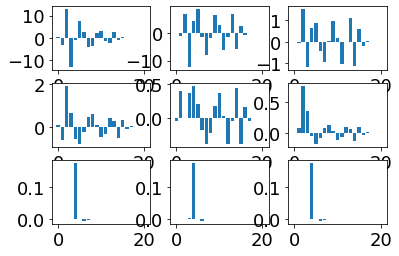

In [30]:
n = 100
L = 4
x = np.linspace(0,L,n)
f = np.power(x,2) # parabola with 100 data points

M = 21 # Polynomial degree
phi = np.zeros((n,M))
for j in range(M):
    phi[:,j] = np.power(x,j) # build matrix A
    
trials = np.array([2, 10, 100])

fig,axs = plt.subplots(3,3)

for j in range(len(trials)):
    trial = trials[j]
    E1 = np.zeros(trial)
    E2 = np.zeros(trial)
    E3 = np.zeros(trial)
    
    A1 = np.zeros((M,trial))
    A2 = np.zeros((M,trial))
    A3 = np.zeros((M,trial))

    
    for jj in range(trial):
        f = np.power(x,2) + 0.2*np.random.randn(n)
        a1 = np.linalg.pinv(np.copy(phi)) @ np.copy(f)
        f1 = phi @ a1
        E1[jj] = np.linalg.norm(f-f1,ord=2)/np.linalg.norm(f,ord=2)
        
        a2 = np.linalg.lstsq(np.copy(phi),np.copy(f),rcond=None)[0]
        f2 = phi @ a2
        E2[jj] = np.linalg.norm(f-f2,ord=2)/np.linalg.norm(f,ord=2)
        
#         regr3 = linear_model.ElasticNet(alpha=1.0, copy_X=True, l1_ratio=0.1, max_iter=10**5,random_state=0)
        regr3 = linear_model.Lasso(alpha=1)
        regr3.fit(phi, f)  
        a3 = regr3.coef_
        f3 = phi @ a3
        E3[jj] = np.linalg.norm(f-f3,ord=2)/np.linalg.norm(f,ord=2)
        
        A1[:,jj] = a1
        A2[:,jj] = a2
        A3[:,jj] = a3
        
    A1m = np.mean(A1,axis=1)
    A2m = np.mean(A2,axis=1)
    A3m = np.mean(A3,axis=1)
    
    Err = np.column_stack((E1,E2,E3))
    
    axs[0,j].bar(range(M),A1m)
    axs[1,j].bar(range(M),A2m)
    axs[2,j].bar(range(M),A3m)
    
plt.show()

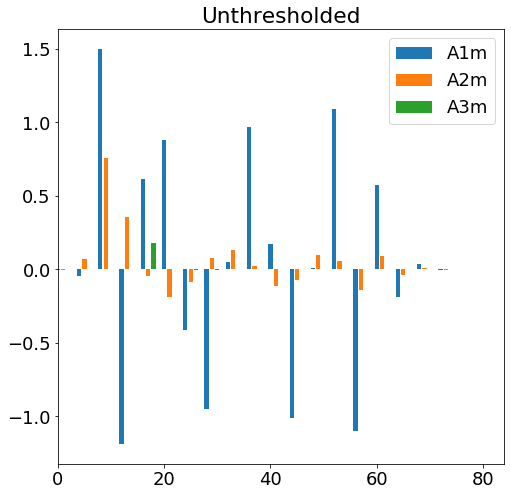

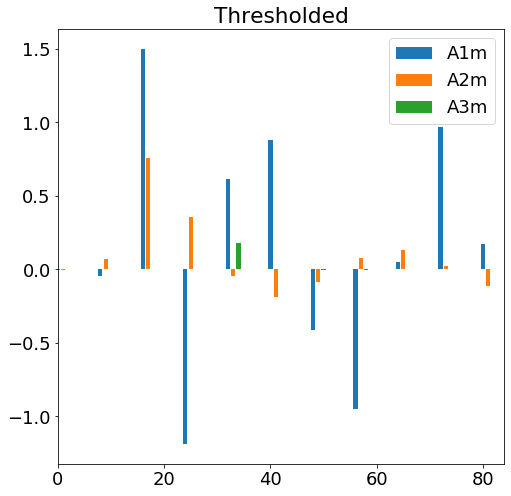

In [51]:
plt.rcParams['figure.figsize'] = [8,8]

Atot = np.column_stack((A1m,A2m,A3m)) # Average loadings of three methods
Atot2 = (Atot>0.2) * Atot # threshold
Atot3 = np.column_stack((Atot,Atot2)) # combine both thresholded and not

for j in range(3):
    plt.bar(np.arange(Atot.shape[0])*4+j,Atot[:,j],label='A'+str(j+1)+'m')
    
plt.xlim(0,4*M)
plt.title('Unthresholded')
plt.legend()

plt.figure()
for j in range(3):
    plt.bar(np.arange(Atot2.shape[0])*8+j,Atot[:,j],label='A'+str(j+1)+'m')
    
plt.title('Thresholded')
plt.xlim(0,4*M)
plt.legend()

plt.show()



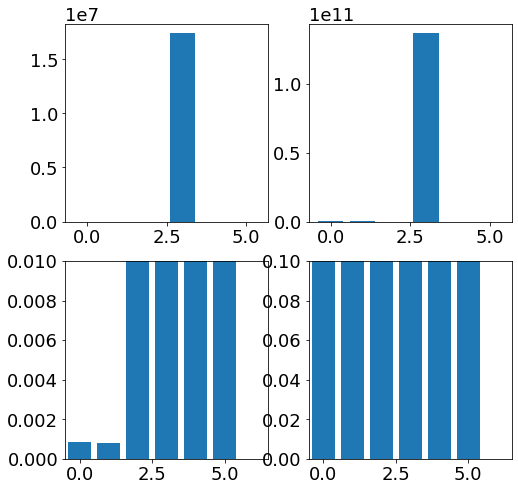

In [69]:
n = 200
L = 8
x = np.linspace(0,L,n)
x1 = x[:100]    # Train
x2 = x[100:200] # Test
n1 = len(x1)
n2 = len(x2)
ftrain = np.power(x1,2) # Train parabola x = [0,4]
ftest = np.power(x2,2)  # Test parabola x = [4,8]

phi_i = np.zeros((n1,M))
phi_e = np.zeros((n2,M))

for j in range(M):
    phi_i[:,j] = np.power(x1,j) # interpolation key
    phi_e[:,j] = np.power(x2,j) # extrapolation key
    
Eni = np.zeros(6)
Ene = np.zeros(6)
for jj in range(6): # compute inter/extra-polation scores
    ani = Atot3[:,jj]
    fnai = phi_i @ ani
    Eni[jj] = np.linalg.norm(ftrain-fnai,ord=2)/np.linalg.norm(ftrain,ord=2)
    fnae = phi_e @ ani
    Ene[jj] = np.linalg.norm(ftest-fnae,ord=2)/np.linalg.norm(ftest,ord=2)
    
fig,axs = plt.subplots(2,2)
axs[0,0].bar(range(6),Eni)
axs[0,1].bar(range(6),Ene)
axs[1,0].bar(range(6),Eni)
axs[1,0].set_xlim(-0.5,6.5)
axs[1,0].set_ylim(0,0.01)
axs[1,1].bar(range(6),Ene)
axs[1,1].set_xlim(-0.5,6.5)
axs[1,1].set_ylim(0,0.1)

plt.show()